# SENTIMENT ANALYSIS OF AIRLINE TWEETS

# Business Understanding

## Overview
In the highly competitive airline industry, leveraging sentiment analysis can provide a competitive edge. By analyzing various sources of customer feedback, such as social media posts, sentiment analysis can determine whether the sentiment of the feedback is positive, negative, or neutral. This can provide valuable insights into customers' opinions and preferences, aid in identifying common complaints, monitor trends in customer feedback, and enable the development of targeted strategies to enhance customer satisfaction and loyalty. Employing sentiment analysis can lead to data-driven decisions, improving overall performance and reputation, and resulting in increased profitability and success.

## Business Problem

The airline industry faces various challenges, including high operational costs, security concerns, environmental impact, and fierce competition. In Kenya, for example, the national carrier Kenya Airways has been struggling financially as a result of some of these challenges. To remain competitive in such a challenging environment, airlines need to find innovative ways to improve their service offerings while keeping operational costs low. One way to achieve this is by leveraging sentiment analysis to better understand customer preferences and improve overall customer satisfaction.<br>
Therefore, we aim to use Natural Language Processing (NLP) to provide valuable insights into customer preferences and improve the overall customer experience which will consequently improve the airline's competitiveness.

## Objectives

To build a machine learning model that accurately predicts the sentiment of airline passengers based on their tweets.

### Specific objectives

1.	To use NLP techniques to preprocess and clean the customer feedback dataset to prepare it for sentiment analysis.
2.	To apply sentiment analysis techniques to categorize the customer feedback into positive, negative, or neutral sentiments.
3.	To determine the model’s effectiveness in predicting the sentiment of airline passengers based on recall and F1-score metrics.
4.	To interpret the model results and gain insights into the factors that influence customer satisfaction and dissatisfaction with the airline.


## Success Criteria

A model will be considered a success when it is able to correctly identify all tweets with positive, negative or neutral sentiment. For an airline, missing a tweet that expresses negative sentiment could lead to the airline missing an opportunity to address the issue and potentially lose a customer. Therefore, high recall is crucial in order to capture all relevant tweets expressing positive, negative or neutral sentiment, and take appropriate actions accordingly.<br>
However, a model with high recall may also classify a large number of irrelevant tweets as positive, which would lower its precision and potentially mislead the interpretation of the sentiment analysis results. F1 score will be used as a secondary metric, to provide a balance between recall and precision.

# Exploratory Data Analysis

#### Importing the Libraries

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading the Data

In [3]:
data = pd.read_csv('airline_tweets.csv')

data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### Shape of the data

In [4]:
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns')

The data has 14640 rows and 15 columns


#### Data Types and missing values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Convering the tweet_created column to date-time

In [6]:
data['tweet_created'] = pd.to_datetime(data['tweet_created'])

data['tweet_created'].dtype

datetime64[ns, pytz.FixedOffset(-480)]

#### Checking for Duplicates

In [7]:
data.duplicated().sum()

36

#### Previewing the duplicated data

In [8]:
duplicated = data[data.duplicated(keep=False)]

duplicated.sort_values(by='name') 

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11898,570305051819941889,neutral,1.0,NaN,NaN,American,NaN,Chandrafaythe,NaN,0,@AmericanAir my flight got Cancelled Flightled...,NaN,2015-02-24 11:31:34-08:00,NaN,Quito
12059,570305051819941889,neutral,1.0,NaN,NaN,American,NaN,Chandrafaythe,NaN,0,@AmericanAir my flight got Cancelled Flightled...,NaN,2015-02-24 11:31:34-08:00,NaN,Quito
11998,570272880556011520,positive,1.0,NaN,NaN,American,NaN,ESPartee,NaN,0,"@americanair new plane, #gogo, easy power for ...","[0.0, 0.0]",2015-02-24 09:23:44-08:00,"alexandria, va",Eastern Time (US & Canada)
12159,570272880556011520,positive,1.0,NaN,NaN,American,NaN,ESPartee,NaN,0,"@americanair new plane, #gogo, easy power for ...","[0.0, 0.0]",2015-02-24 09:23:44-08:00,"alexandria, va",Eastern Time (US & Canada)
11905,570301929580048385,neutral,1.0,NaN,NaN,American,NaN,FinEdChat,NaN,0,@AmericanAir I did,NaN,2015-02-24 11:19:10-08:00,"Cincinnati, Ohio",Atlantic Time (Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11965,570281731510571009,negative,1.0,Customer Service Issue,1.0,American,NaN,robkoenigld,NaN,0,@AmericanAir why am I continually getting put ...,NaN,2015-02-24 09:58:54-08:00,"indialantic, fl",Eastern Time (US & Canada)
11973,570279653337927680,positive,1.0,NaN,NaN,American,NaN,sundialtours,NaN,0,"@AmericanAir ""Airport snow removal method #22....",NaN,2015-02-24 09:50:39-08:00,"Astoria, OR",Tijuana
12134,570279653337927680,positive,1.0,NaN,NaN,American,NaN,sundialtours,NaN,0,"@AmericanAir ""Airport snow removal method #22....",NaN,2015-02-24 09:50:39-08:00,"Astoria, OR",Tijuana
12063,570303383782989824,neutral,1.0,NaN,NaN,American,NaN,trentgillaspie,NaN,0,.@AmericanAir just disappointed with the Fligh...,NaN,2015-02-24 11:24:57-08:00,"Austin, but often Denver",Mountain Time (US & Canada)


#### Dropping the Duplicated rows:

In [9]:
data = data.drop_duplicates()

data.duplicated().sum()

0

### Mapping the tweets with coordinate values

In [10]:
tweet_coord = data[data['tweet_coord'].isnull() == False]

tweet_coord['tweet_coord']

21        [40.74804263, -73.99295302]
28          [42.361016, -71.02000488]
29        [33.94540417, -118.4062472]
32       [33.94209449, -118.40410103]
34          [33.2145038, -96.9321504]
                     ...             
14577    [33.93939612, -118.38973148]
14596    [35.22534456, -106.57241352]
14612     [40.46692522, -82.64567078]
14624      [32.9070889, -97.03785947]
14625     [40.64946781, -73.76624703]
Name: tweet_coord, Length: 1015, dtype: object

In [11]:
# uncomment to install folium

# !pip install folium

# importing folium and ast
import ast
import folium

In [12]:
# Define a function to filter ignore invalid coordinates
def parse_coord(coord_str):
    try:
        coord_list = ast.literal_eval(coord_str)
        if isinstance(coord_list, list) and len(coord_list) == 2:
            return coord_list
    except (SyntaxError, ValueError):
        pass
    return [0, 0]

# create a column with parsed coordinates
data['parsed_coord'] = data['tweet_coord'].apply(parse_coord)

In [13]:
# create a map object centered at the first coordinate
map_object = folium.Map(location=data['parsed_coord'].iloc[0], zoom_start=2, zoom_control=False)

sample_coord = data['parsed_coord'].sample(n=2000, random_state=42)
# loop over each coordinate sample in the column and create a marker for it
for coord in sample_coord:
    marker = folium.Marker(location=(coord[0], coord[1]))
    marker.add_to(map_object)

# display the map
map_object

Note: Most of the tweets with coordinates are from USA.

#### Number of Tweets Per Airline

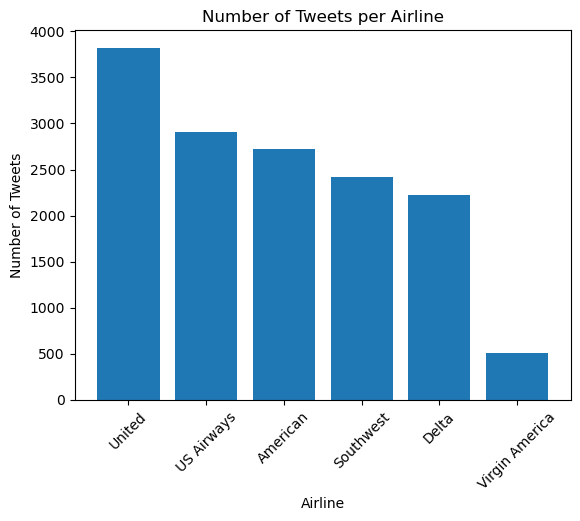

In [14]:
# Count the number of tweets per airline
tweets_per_airline = data['airline'].value_counts()

# Sort the values in descending order
tweets_per_airline = tweets_per_airline.sort_values(ascending=False)

# Plot the bar graph
plt.bar(tweets_per_airline.index, tweets_per_airline.values)
plt.title('Number of Tweets per Airline')
plt.xlabel('Airline')
plt.xticks(rotation=45)
plt.ylabel('Number of Tweets')
plt.show()

#### Displaying tweets trend over time

In [15]:
# print the range of dates
print('Earliest tweet:', data['tweet_created'].min())
print('Latest tweet:', data['tweet_created'].max())

Earliest tweet: 2015-02-16 23:36:05-08:00
Latest tweet: 2015-02-24 11:53:37-08:00


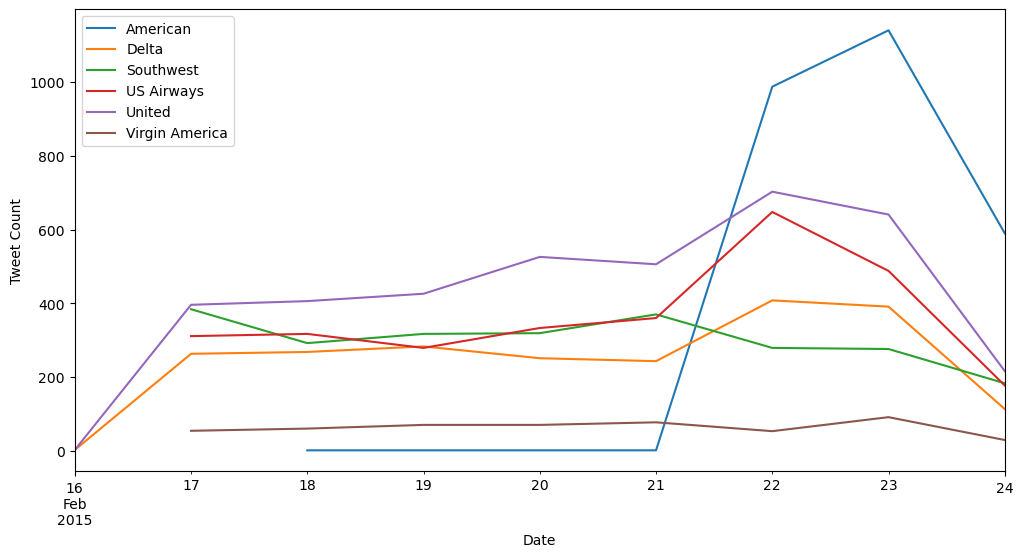

In [16]:
import matplotlib.pyplot as plt


# group the data by airline and date, count the number of tweets
tweet_count = data.groupby(['airline', pd.Grouper(key='tweet_created', freq='D')]).size().reset_index(name='count')

# plot a bar chart of the tweet count by airline and date
fig, ax = plt.subplots(figsize=(12,6))
for airline, values in tweet_count.groupby('airline'):
    ax = values.plot(x='tweet_created', y='count', ax=ax, label=airline)
    
ax.set_xlabel('Date')
ax.set_ylabel('Tweet Count')
ax.legend()
plt.show()


Note: There is a spike in the number of tweets on 21st February to 23rd.

#### Tweets Word Cloud

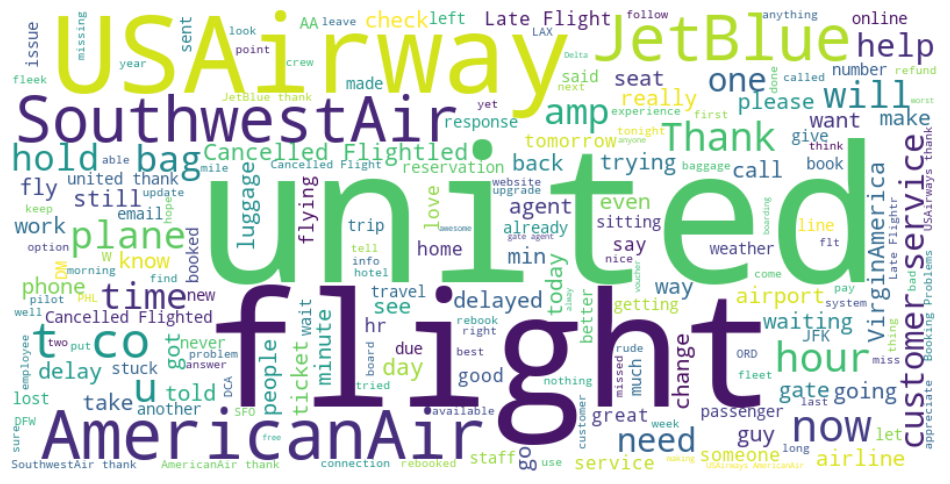

In [17]:
# !pip install wordcloud

# Creating a word cloud of the tweets

from wordcloud import WordCloud

# concatenate all the tweets into a single string
all_tweets = ' '.join(data['text'].values)

# create a WordCloud object
wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_tweets)

# display the word cloud
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Note: The tags in the text have the highest frequency and removing them would provide a better understanding on the topics. However, time is prominent with variations such as hour, minute, late flight, now, and delay. Other frequest words or phrases are customer service, thank, cancelled, great, need.